In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
root_dir
save = False

ml_dir: /home/lorenzo/Desktop/mimic-2/src/ml | src_dir: /home/lorenzo/Desktop/mimic-2/src | entry_dir: /home/lorenzo/Desktop/mimic-2 




In [2]:
# Path
log_dir_path = os.path.join(root_dir, 'log')
trace_dir_path = os.path.join(log_dir_path, 'mab', 'trace')
path_to_save_dir = "/home/lorenzo/Desktop/mimic-2/analysis/plots/kernel_features"

In [4]:
import re
from datetime import datetime

# Get iperf config
def get_timestamp_from_config(tag):
    iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
    ts_list = []
    latest_timestamp = None

    for config_file in os.listdir(iperf_test_dir_path):
        if config_file.startswith(tag):
            full_path = os.path.join(iperf_test_dir_path, config_file)
            pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
            match = re.search(pattern, config_file)
            if not match:
                continue
            timestamp_str = match.group(0)
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
            ts_list.append(timestamp)
            # check if this timestamp is more recent
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_timestamp = timestamp
                latest_ts_str = timestamp_str
    print(latest_ts_str)
    return latest_ts_str

In [5]:
# Get the kernel features from csv
def get_features_from_file(csv_filename):
    keys = {'action': 0, 'cwnd': 1, 'rtt': 2, 'rtt_dev': 3, 'delivered': 4, 'delivered_diff': 5, 'lost': 6, 'in_flight': 7, 'retrans': 8, 'cwnd_diff': 9, 'step': 10, 'curr_reward': 11, 'reward': 12}

    import csv

    features = []
    file_path = os.path.join(trace_dir_path, csv_filename)
    # Loop through each row in the CSV file
    with open(file_path, 'r') as csvfile:    # Create a CSV reader using the 'csv' module
        reader = csv.reader(csvfile)    
        for row in reader:
            # Extract the numbers from the row and append them to the features list
            numbers = [float(x) for x in row]
            if len(numbers) > 0:
                features.append({key: float(row[value]) for key, value in keys.items()})
    return features

def get_csv_filename(trace, policy, timestamp):
    for filename in os.listdir(trace_dir_path):
            if filename.startswith(trace) and filename.find(policy) != -1 and filename.endswith(timestamp+'.csv'):
                return filename


In [57]:
# keys = {'action': 0, 'cwnd': 1, 'rtt': 2, 'rtt_dev': 3, 'delivered': 4, 'delivered_diff': 5, 'lost': 6, 'in_flight': 7, 'retrans': 8, 'cwnd_diff': 9, 'step': 10, 'curr_reward': 11, 'reward': 12}
# import csv

# features = []
# csv_filename = os.path.join(trace_dir_path, 'att.lte.driving.2016.adaptive_greedy_threshold.2023.03.23.20.51.42.csv')
# # Loop through each row in the CSV file
# with open(csv_filename, 'r') as csvfile:    # Create a CSV reader using the 'csv' module
#     reader = csv.reader(csvfile)    
#     for row in reader:
#         # Extract the numbers from the row and append them to the features list
#         numbers = [float(x) for x in row]
#         if len(numbers) > 0:
#             features.append({key: float(row[value]) for key, value in keys.items()})

# features

In [6]:
import matplotlib.pyplot as plt
import numpy as np
#  Get csv filename
policy = "bootstrapped_ucb"
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]

2023.04.20.09.31.16
/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.bootstrapped_ucb.2023.04.20.09.31.16.csv


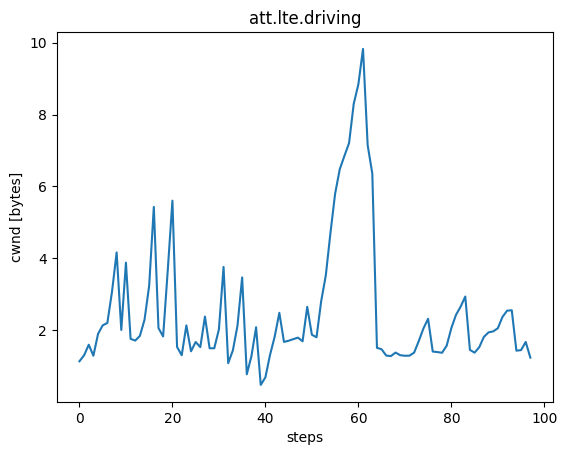

2023.04.20.09.32.21
/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.2016.bootstrapped_ucb.2023.04.20.09.32.21.csv


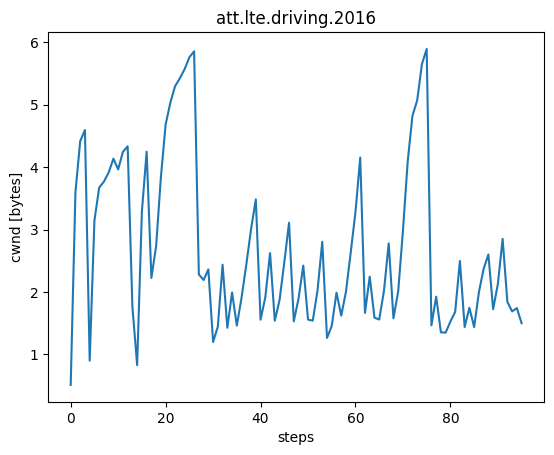

2023.04.20.09.33.24
/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.driving.bootstrapped_ucb.2023.04.20.09.33.24.csv


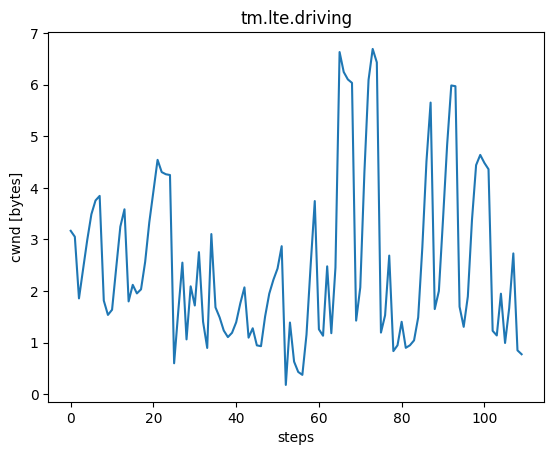

2023.04.20.09.34.29
/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.short.bootstrapped_ucb.2023.04.20.09.34.29.csv


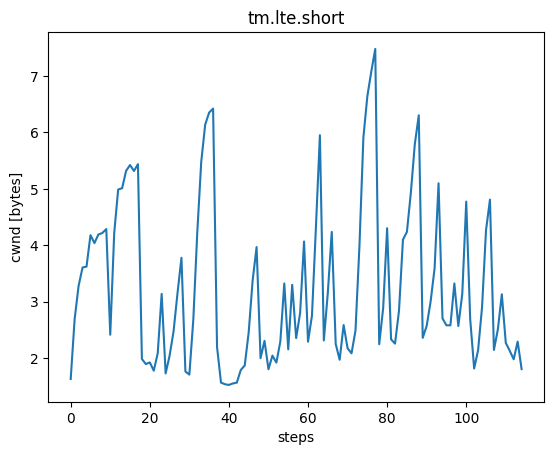

2023.04.20.09.35.32
/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.umts.driving.bootstrapped_ucb.2023.04.20.09.35.32.csv


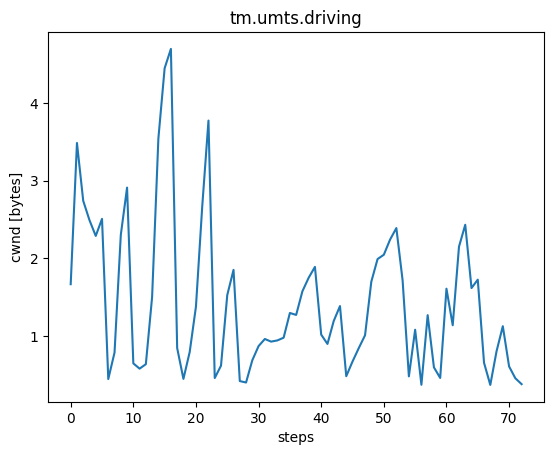

2023.04.20.09.36.42
/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.evdo.driving.bootstrapped_ucb.2023.04.20.09.36.42.csv


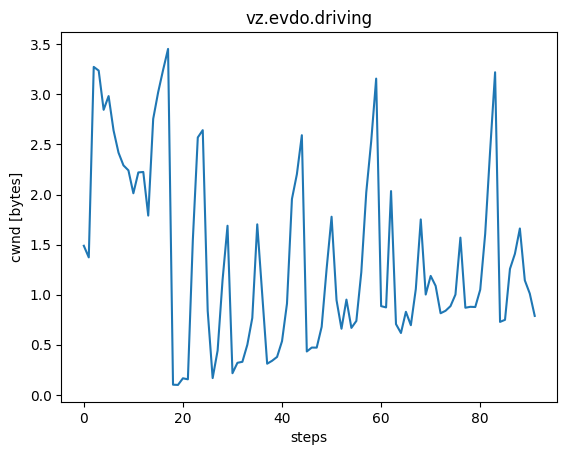

2023.04.20.09.37.48
/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.driving.bootstrapped_ucb.2023.04.20.09.37.48.csv


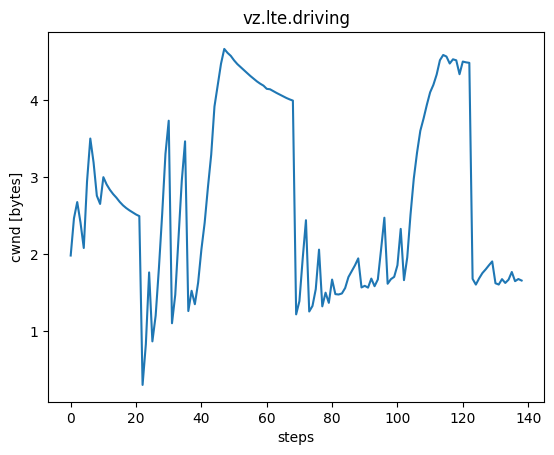

2023.04.20.09.39.05
/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.short.bootstrapped_ucb.2023.04.20.09.39.05.csv


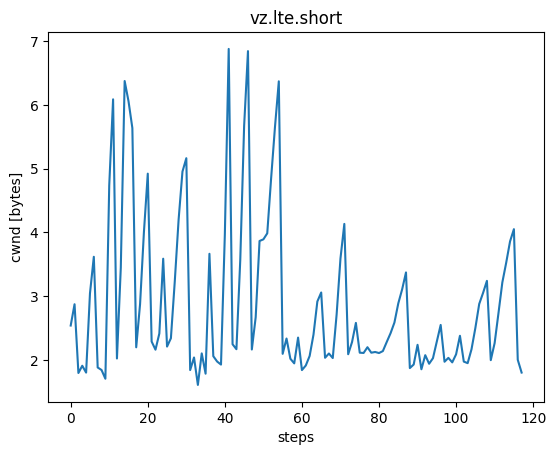

2023.04.20.09.40.09
/home/lorenzo/Desktop/mimic-2/log/mab/trace/bus.bootstrapped_ucb.2023.04.20.09.40.09.csv


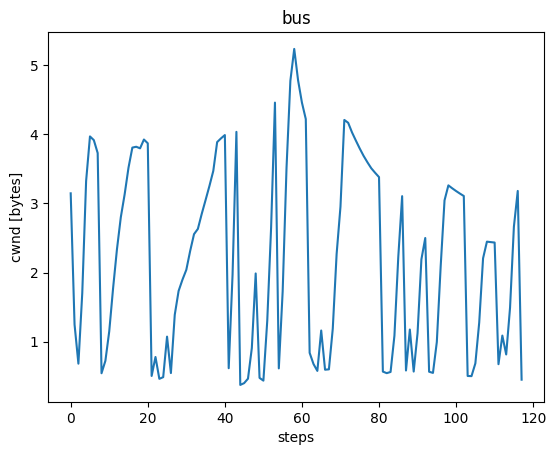

2023.04.20.09.41.12
/home/lorenzo/Desktop/mimic-2/log/mab/trace/timessquare.bootstrapped_ucb.2023.04.20.09.41.12.csv


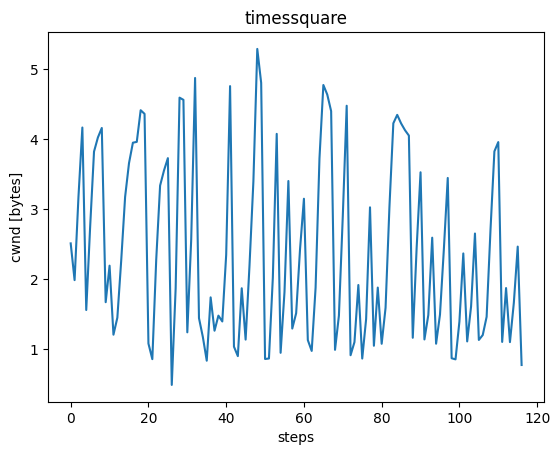

2023.04.20.09.42.16
/home/lorenzo/Desktop/mimic-2/log/mab/trace/wired.bootstrapped_ucb.2023.04.20.09.42.16.csv


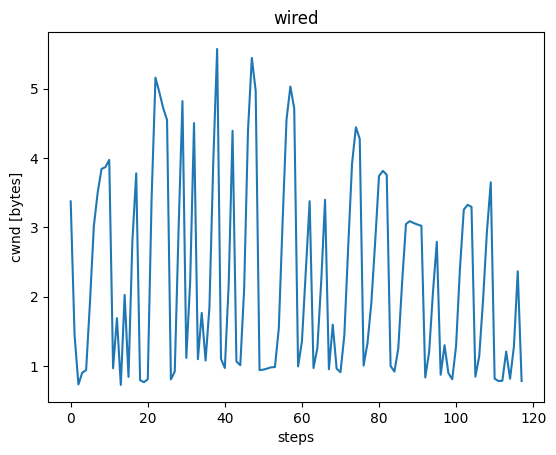

In [7]:
# Plot cwnd
for trace in traces:
    timestamp = get_timestamp_from_config(f"{trace}.{policy}")
    csv_filename = get_csv_filename(trace, policy, timestamp)
    if csv_filename==None:
        print(trace, timestamp)
        break
    features = get_features_from_file(csv_filename)
    # Extract congestion window values
    cwnds = []
    for row in features:
        cwnds.append(row['cwnd'])
    # Plot cwnd
    plt.figure()
    print(os.path.join(trace_dir_path, csv_filename))
    plt.plot(np.arange(len(cwnds)), cwnds)
    plt.title(trace)
    plt.xlabel('steps')
    plt.ylabel('cwnd [bytes]')

    plt.show()

In [ ]:
# # Plot protocol selection
# for trace in traces:
#     timestamp = get_timestamp_from_config(f"{trace}.{policy}")
#     csv_filename = get_csv_filename(trace, policy, timestamp)
#     features = get_features_from_file(csv_filename)
#     # Extract congestion window values
#     actions = []
#     for row in features:
#         actions.append(row['action'])
#     # Plot cwnd
#     plt.figure()
#     plt.plot(np.arange(len(actions)), actions, marker='o', linestyle='None')
#     plt.title(trace)
#     plt.xlabel('steps')
#     plt.ylabel('protocol')
#     plt.yticks([0, 1, 2], ['cubic', 'bbr', 'hybla'])

2023.04.20.09.31.16
2023.04.20.09.32.21
2023.04.20.09.33.24
2023.04.20.09.34.29
2023.04.20.09.35.32
2023.04.20.09.36.42
2023.04.20.09.37.48
2023.04.20.09.39.05
2023.04.20.09.40.09
2023.04.20.09.41.12
2023.04.20.09.42.16


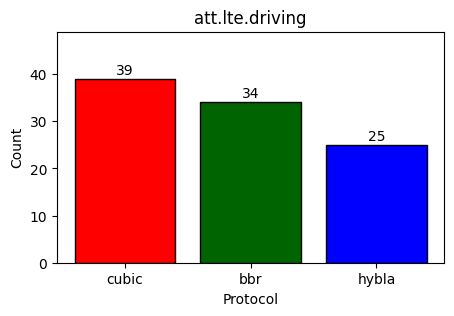

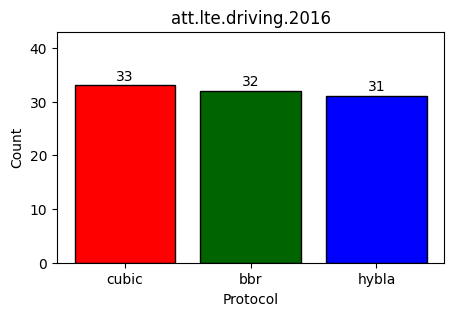

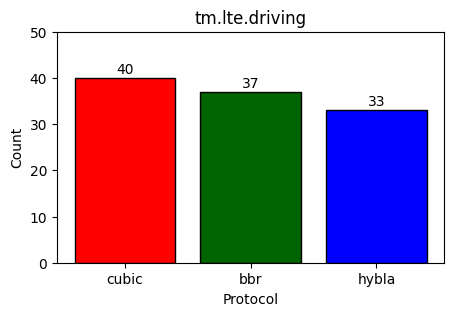

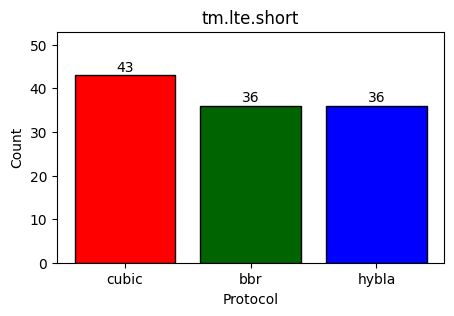

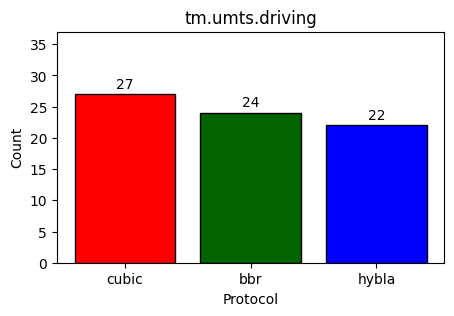

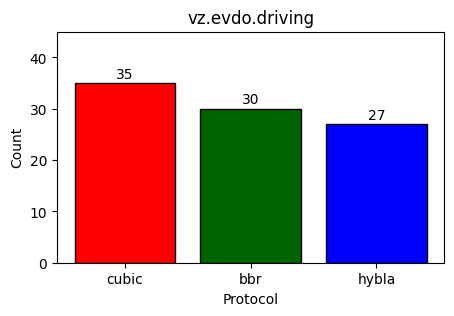

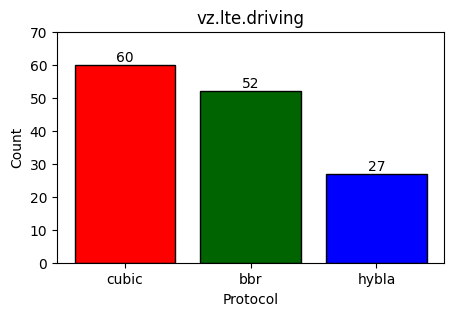

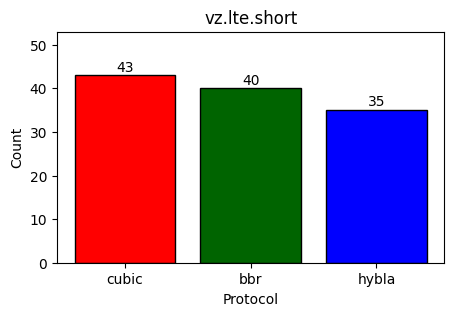

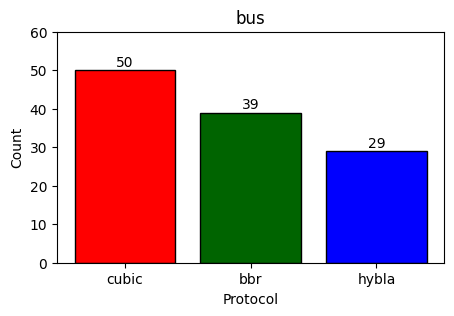

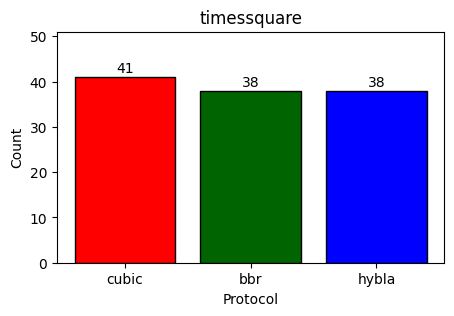

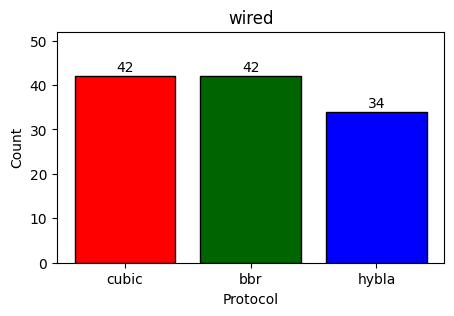

In [8]:
import pandas as pd

for trace in traces:
    timestamp = get_timestamp_from_config(f"{trace}.{policy}")
    csv_filename = get_csv_filename(trace, policy, timestamp)
    features = get_features_from_file(csv_filename)
    actions = []
    for row in features:
        actions.append(row['action'])
        df = pd.DataFrame(actions, columns=['protocol'], dtype=int)
    action_count = df['protocol'].value_counts()
    fig, ax = plt.subplots(figsize=(5,3))
    ax.bar(['cubic', 'bbr', 'hybla'], action_count.values, edgecolor='black', color=['red', 'darkgreen', 'blue'])

    # Add count labels to each bar
    for i, v in enumerate(action_count.values):
        ax.text(i, v + 1, str(v), ha='center', color='black')

    # Set the axis labels
    ax.set_xlabel('Protocol')
    ax.set_ylabel('Count')
    ax.set_ylim(top=max(action_count)+10)
    ax.set_title(trace)

    if save:
        filename = f'mab.{policy}.{trace}.action_count.png'
        plt.savefig(os.path.join(path_to_save_dir, filename))

2023.04.20.09.31.16
2023.04.20.09.32.21
2023.04.20.09.33.24
2023.04.20.09.34.29
2023.04.20.09.35.32
2023.04.20.09.36.42
2023.04.20.09.37.48
2023.04.20.09.39.05
2023.04.20.09.40.09
2023.04.20.09.41.12
2023.04.20.09.42.16


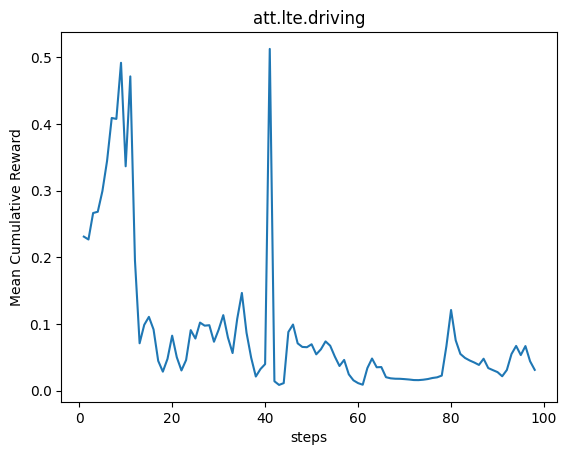

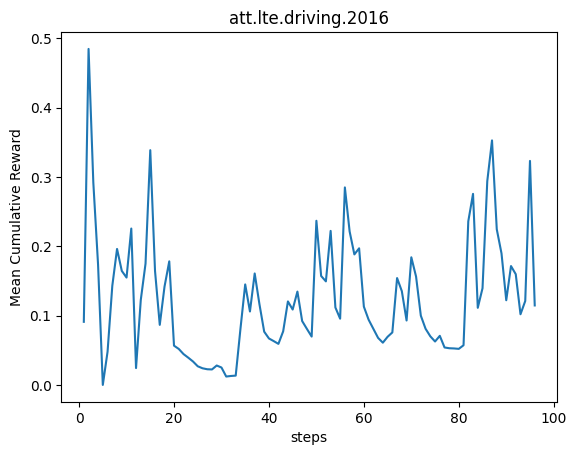

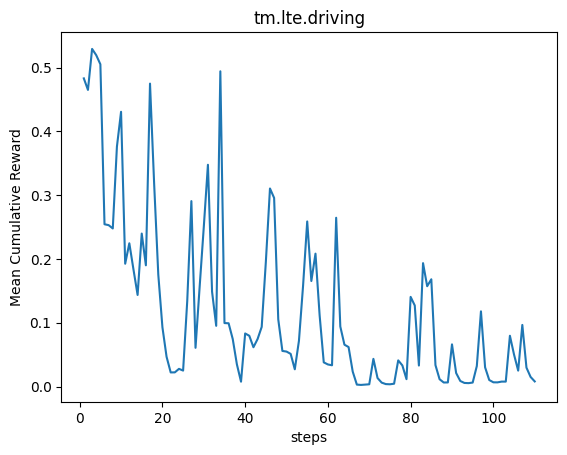

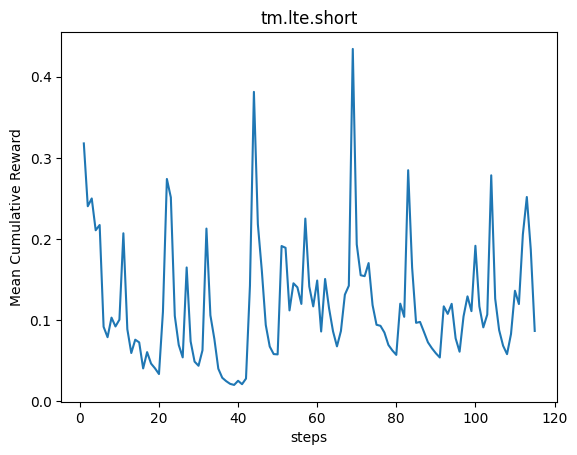

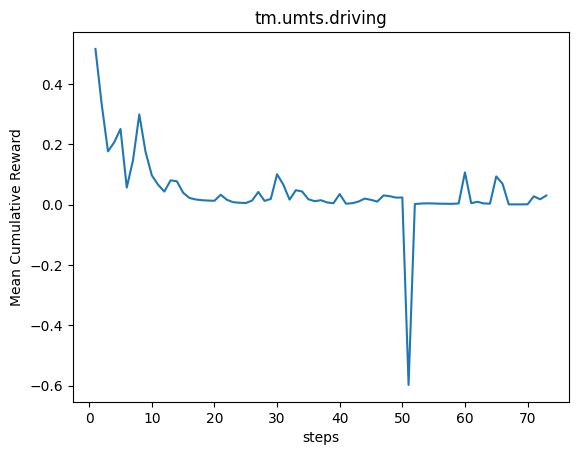

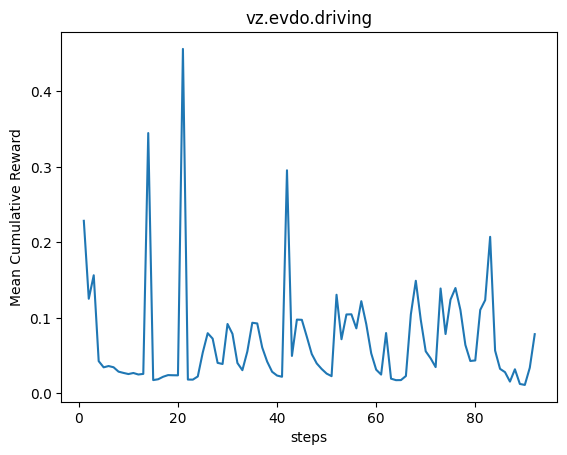

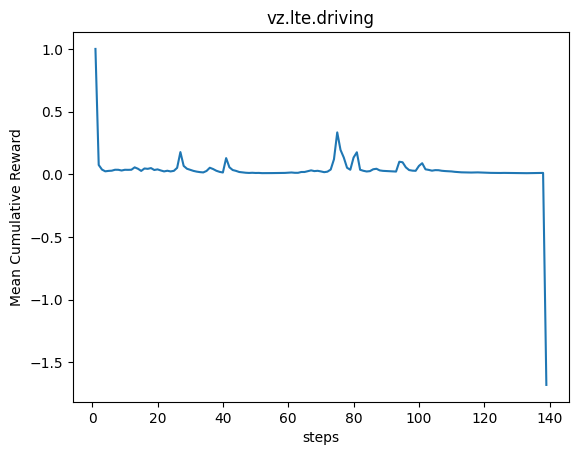

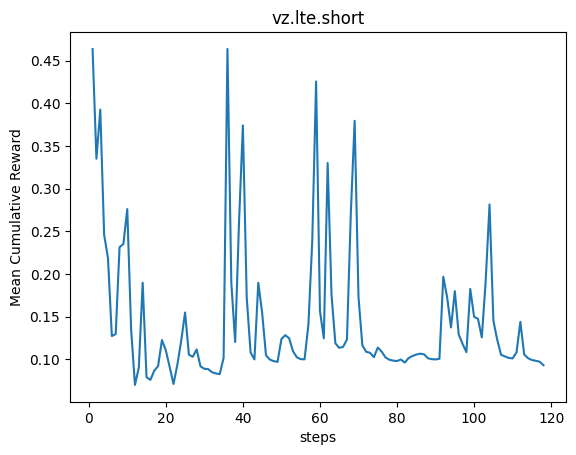

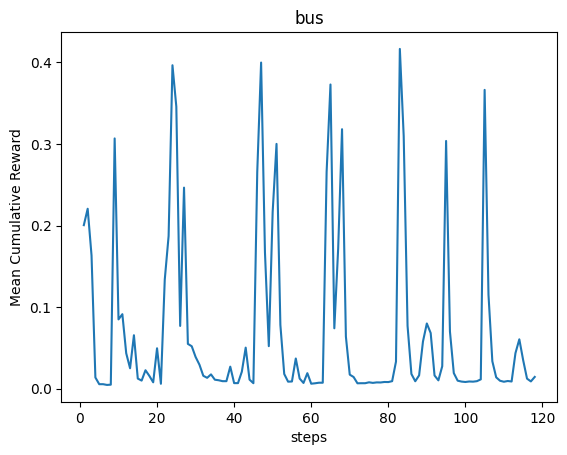

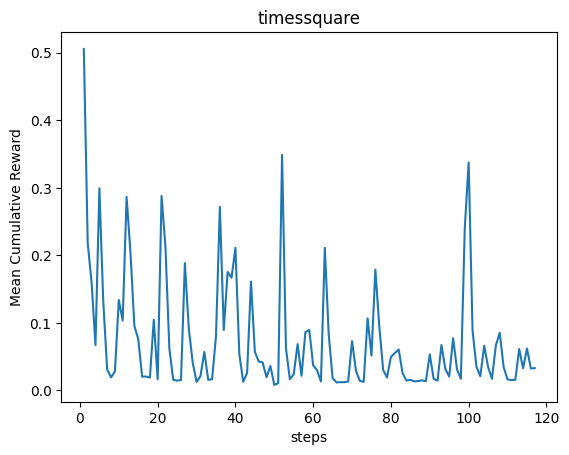

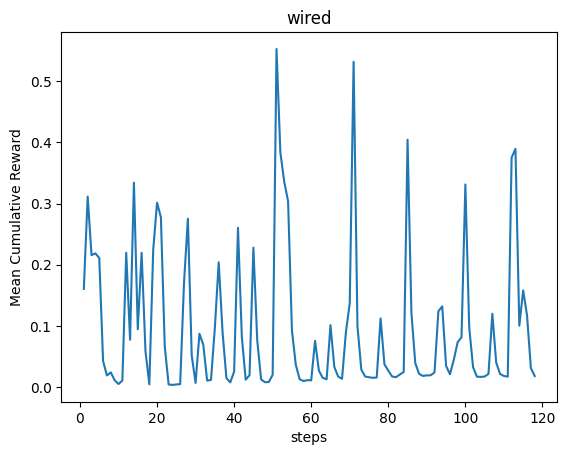

In [9]:
# Plot protocol selection
for trace in traces:
    timestamp = get_timestamp_from_config(f"{trace}.{policy}")
    csv_filename = get_csv_filename(trace, policy, timestamp)
    features = get_features_from_file(csv_filename)
    # Extract congestion window values
    rewards, steps = [], []
    for row in features:
        rewards.append(row['curr_reward'])
        steps.append(row['step'])
    # Plot cwnd
    plt.figure()
    plt.plot(steps, rewards)
    plt.title(trace)
    plt.xlabel('steps')
    plt.ylabel('Mean Cumulative Reward')